In [ ]:
## Experiment: SBI

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

from numba import njit
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

import matplotlib.tri as tri
from scipy import stats
from sklearn.metrics import confusion_matrix
from scipy.special import gamma as gamma_fun
import scipy.special as spec
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [2]:
from bayesflow.networks import SequenceNet, EvidentialNetwork
from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.models import GenerativeModel
from bayesflow.amortizers import MultiModelAmortizer
from bayesflow.diagnostics import plot_confusion_matrix, plot_calibration_curves, expected_calibration_error

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    #"text.usetex": True,
    #"font.family": "serif",
    #"font.serif": ["times"],
    #'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

FILEFORMAT = 'pdf'
DPI = 300

In [5]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.tri as tri

def xy2bc(xy, corners, midpoints, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet:
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, ax=None, f=None, **kwargs):
    
    
    if ax is None and f is None:
        f, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy, corners, midpoints)) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    return f

In [6]:
def build_viridis_palette(n, n_total=20, base_palette="viridis"):
    """
    Builds a viridis palette with maximal entropy (evenly spaced)
    """
    color_palette = np.array(sns.color_palette(base_palette, n_colors=n_total))
    indices = np.array(np.floor(np.linspace(0, n_total-1, n)), dtype=np.int32)
    color_palette = color_palette[indices]
    return [tuple(c) for c in color_palette]

color_codes = dict(zip([f"M{i}" for i in range(1, 5)], build_viridis_palette(5)[0:4]))

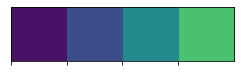

In [7]:
sns.palplot(color_codes.values())

## Simulator settings

### Model prior
Implements sampling from $p(M)$.

In [8]:
def model_prior(batch_size, n_models=3, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------

    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    ----------

    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1 / n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

### Parameter priors
Implements sampling from each $p(\theta_j\,|\,M_j)$.

In [9]:
def model1_params_prior(**args):
    """
    Samples from the prior of the HH-1pars theta = (gbar_Na)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
         np.random.uniform(low=1.5, high=30)    # gbar_Na
    ]
    return np.array(theta)

def model2_params_prior(**args):
    """
    Samples from the prior of the HH-2pars theta = (gbar_Na,gbar_K)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
         np.random.uniform(low=1.5, high=30),  # gbar_Na
         np.random.uniform(low=0.3, high=15)   # gbar_K
    ]
    return np.array(theta)


def model3_params_prior(**args):
    """
     Samples from the prior of the HH-3pars theta = (gbar_Na,gbar_K,gbar_M)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=1.5, high=30),   # gbar_Na
        np.random.uniform(low=0.3, high=15),   # gbar_K
        np.random.uniform(low=0.005, high=0.3) # gbar_M
    ]
    return np.array(theta)

def model4_params_prior(**args):
    """
    Samples from the prior of the HH-4pars theta = (gbar_l,gbar_Na,gbar_K,gbar_M)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0.01, high=0.18), # gbar_l
        np.random.uniform(low=1.5, high=30),    # gbar_Na
        np.random.uniform(low=0.3, high=15),    # gbar_K
        np.random.uniform(low=0.005, high=0.3)  # gbar_M
    ]
    return np.array(theta)

### Simulators
Implements each forward model (stochastic simulator) $g_j(\theta_j,\xi)$. Uses $numba$ for just-in-time compilation (i.e., speed).

In [10]:
#@njit
def forward_model1(params, n_obs, V0=-70, I_input=3, dt=0.2):
    # HH-1pars

    # pars = [gbar_Na]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt

    I_duration = n_obs
    gbar_Na = params

    # fixed parameters
    tau_max = 6e2  # ms
    Vt = -60.  # mV
    nois_fact = 0.1  # uA/cm2
    E_leak = -70.  # mV
    E_Na = 53  # mV
    E_K = -107  # mV
    C = 1
    g_l = 0.1
    gbar_M = 0.07
    gbar_K = 2.0 # fixed K

    tstep = float(dt)

    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_post = 10
    I_duration = np.round(n_obs * dt - t_on - t_post - dt, 2)
    assert I_duration > 0, "Please provide n_obs >= 106!"
    t_off = I_duration + t_post

    t = np.arange(0, np.round(t_on + t_off + dt, 2), dt)

    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)):int(np.round(t_off / dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128 * np.exp(-v1 / 18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0 / (1. + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] + (n[i - 1] ** 4) * gbar_K + g_l + gbar_M * p[i - 1]) / C
        V_inf = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na + (n[i - 1] ** 4) * gbar_K * E_K + g_l * E_leak + gbar_M *
                 p[i - 1] * E_K
                 + I[i - 1] + nois_fact * np.random.randn() / (tstep ** 0.5)) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.expand_dims(V, -1)

#@njit
def forward_model2(params, n_obs, V0=-70, I_input=3, dt=0.2):
    # HH-2pars

    # pars = [gbar_Na, gbar_K]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt

    I_duration = n_obs
    gbar_Na, gbar_K = params

    # fixed parameters
    tau_max = 6e2  # ms
    Vt = -60.  # mV
    nois_fact = 0.1  # uA/cm2
    E_leak = -70.  # mV
    E_Na = 53  # mV
    E_K = -107  # mV
    C = 1
    g_l = 0.1
    gbar_M = 0.07

    tstep = float(dt)

    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_post = 10
    I_duration = np.round(n_obs * dt - t_on - t_post - dt, 2)
    assert I_duration > 0, "Please provide n_obs >= 106!"
    t_off = I_duration + t_post

    t = np.arange(0, np.round(t_on + t_off + dt, 2), dt)

    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)):int(np.round(t_off / dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128 * np.exp(-v1 / 18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0 / (1. + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] + (n[i - 1] ** 4) * gbar_K + g_l + gbar_M * p[i - 1]) / C
        V_inf = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na + (n[i - 1] ** 4) * gbar_K * E_K + g_l * E_leak + gbar_M *
                 p[i - 1] * E_K
                 + I[i - 1] + nois_fact * np.random.randn() / (tstep ** 0.5)) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.expand_dims(V, -1)


#@njit
def forward_model3(params, n_obs, V0=-70, I_input=3, dt=0.2):
    # HH-3pars

    # pars = [gbar_Na, gbar_K, gbar_M]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt

    I_duration = n_obs
    gbar_Na, gbar_K, gbar_M = params

    # fixed parameters
    tau_max = 6e2  # ms
    Vt = -60.  # mV
    nois_fact = 0.1  # uA/cm2
    E_leak = -70.  # mV
    E_Na = 53  # mV
    E_K = -107  # mV
    C = 1
    g_l = 0.1

    tstep = float(dt)

    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_post = 10
    I_duration = np.round(n_obs * dt - t_on - t_post - dt, 2)
    assert I_duration > 0, "Please provide n_obs >= 106!"
    t_off = I_duration + t_post

    t = np.arange(0, np.round(t_on + t_off + dt, 2), dt)

    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)):int(np.round(t_off / dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128 * np.exp(-v1 / 18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0 / (1. + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] + (n[i - 1] ** 4) * gbar_K + g_l + gbar_M * p[i - 1]) / C
        V_inf = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na + (n[i - 1] ** 4) * gbar_K * E_K + g_l * E_leak + gbar_M *
                 p[i - 1] * E_K
                 + I[i - 1] + nois_fact * np.random.randn() / (tstep ** 0.5)) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.expand_dims(V, -1)

#@njit
def forward_model4(params, n_obs, V0=-70, I_input=3, dt=0.2):
    # HH-4pars

    # pars = [gbar_l, gbar_Na, gbar_K, gbar_M]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt

    I_duration = n_obs
    g_l, gbar_Na, gbar_K, gbar_M = params

    # fixed parameters
    tau_max = 6e2  # ms
    Vt = -60.  # mV
    nois_fact = 0.1  # uA/cm2
    E_leak = -70.  # mV
    E_Na = 53  # mV
    E_K = -107  # mV
    C = 1

    tstep = float(dt)

    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_post = 10
    I_duration = np.round(n_obs * dt - t_on - t_post - dt, 2)
    assert I_duration > 0, "Please provide n_obs >= 106!"
    t_off = I_duration + t_post

    t = np.arange(0, np.round(t_on + t_off + dt, 2), dt)

    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)):int(np.round(t_off / dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128 * np.exp(-v1 / 18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0 / (1. + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] + (n[i - 1] ** 4) * gbar_K + g_l + gbar_M * p[i - 1]) / C
        V_inf = ((m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na + (n[i - 1] ** 4) * gbar_K * E_K + g_l * E_leak + gbar_M *
                 p[i - 1] * E_K
                 + I[i - 1] + nois_fact * np.random.randn() / (tstep ** 0.5)) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.expand_dims(V, -1)

## An example amortized model comparison

### Prior predictive checks

In [11]:
# Add your prior predictive checks here

### Train an amortized estimator

In [12]:
evidential_meta = {
    'n_models': 3,
    'out_activation': 'softplus',
    'n_dense': 3,
    'dense_args': {'kernel_initializer': 'glorot_uniform', 'activation': 'relu', 'units': 128}
}
evidential_net = EvidentialNetwork(evidential_meta)

summary_net = SequenceNet()


amortizer = MultiModelAmortizer(evidential_net, summary_net)

In [13]:
priors = [model1_params_prior, model3_params_prior, model4_params_prior]
simulators = [forward_model1, forward_model3, forward_model4]
generative_model = GenerativeModel(model_prior, priors, simulators)

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True,
)

In [15]:
trainer = ModelComparisonTrainer(amortizer, 
                                 generative_model, 
                                 learning_rate=lr_schedule,
                                 skip_checks=True,
                                 checkpoint_path=f'checkpoint_exp2',
                                 max_to_keep=1
                                 )

Initializing networks from scratch.


### Round-based training

In [16]:
%%time
losses = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=16, n_obs=1101)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 2h 20min 58s, sys: 3min 32s, total: 2h 24min 31s
Wall time: 2h 23min 18s


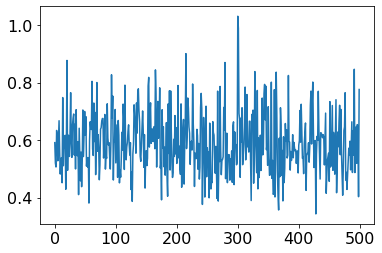

In [31]:
plt.plot(losses[9])

In [ ]:
## Plotting forward model

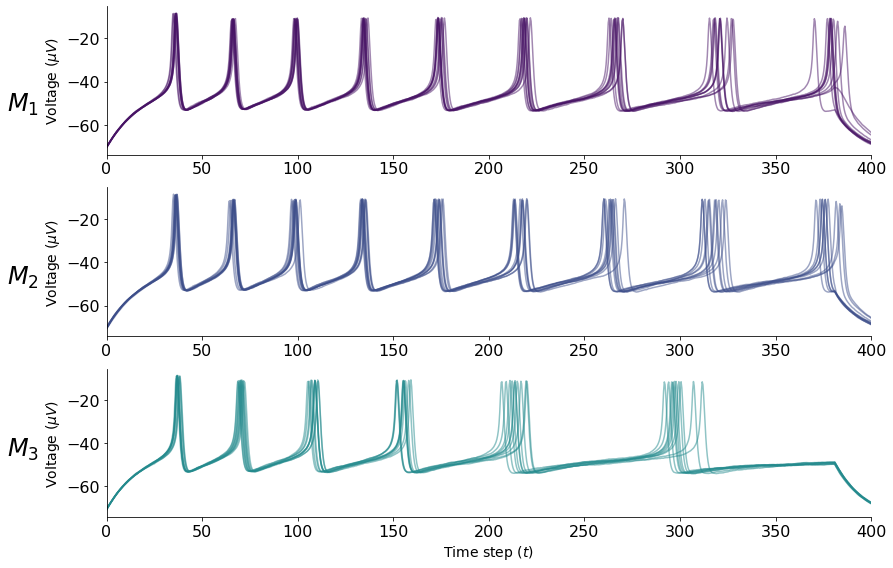

In [32]:
params_1 = np.array([3])
params_2 = np.array([3, 2])
params_3 = np.array([3, 2, 0.1])

t = np.linspace(0, 400, 1051)


f, ax = plt.subplots(3, 1, figsize=(12, 8))
for _ in range(10):
    x1 = forward_model1(params_1, n_obs=1101)
    x2 = forward_model2(params_2, n_obs=1101)
    x3 = forward_model3(params_3, n_obs=1101)
    ax[0].plot(t, x1[50:], label=r'$M_1$', alpha=0.5, lw=1.5, color=color_codes["M1"])
    ax[1].plot(t, x2[50:], label=r'$M_2$', alpha=0.5, lw=1.5, color=color_codes["M2"])
    ax[2].plot(t, x3[50:], label=r'$M_3$', alpha=0.5, lw=1.5, color=color_codes["M3"])
    
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylabel(r'Voltage ($\mu V$)', fontsize=14)
    ax[i].set_xlim([0, 400])
    
ax[2].set_xlabel(r'Time step ($t$)', fontsize=14)
f.tight_layout()

plt.gcf().text(-0.03, 0.8, r'$M_1$', fontsize=24)
plt.gcf().text(-0.03, 0.5, r'$M_2$', fontsize=24)
plt.gcf().text(-0.03, 0.2, r'$M_3$', fontsize=24)

f.savefig('../output/plots/HH_forward_model.pdf', dpi=300, bbox_inches='tight')

## Predictions

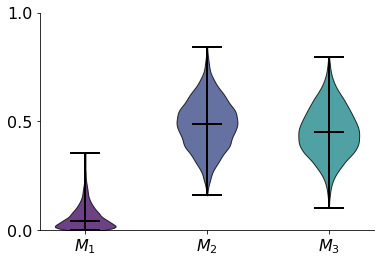

In [33]:
np.random.seed(42)

x1 = tf.convert_to_tensor(
                        forward_model1(np.array([1.2]), n_obs=1101)[np.newaxis, :], dtype=tf.float32
                    )
#x2 = tf.convert_to_tensor(
#                        forward_model2(np.array([3, 6]), n_obs=1101)[np.newaxis, :], dtype=tf.float32
#                    )

for i, x in enumerate([x1], start=1):
    alpha = trainer.network(x).numpy().flatten()
    plt.clf()
    plt.plot(x.numpy()[0, :, 0], color='#871414', lw=2)
    plt.savefig(f"../output/plots/experiment-2-x-{i}.pdf", dpi=300)
    
    plt.clf()
    d_samples = stats.dirichlet.rvs(alpha, size=3000)
    colors = (color_codes["M1"], color_codes["M2"], color_codes["M3"])
    parts = plt.violinplot(d_samples, [0, 1, 2], showmedians=True)
    for c, pc in zip(colors, parts['bodies']):
        pc.set_facecolor(c)
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    for partname in ('cbars','cmins','cmaxes', 'cmedians'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(2)

    #plt.spines['right'].set_visible(False)
    #plt.spines['top'].set_visible(False)
    plt.xticks(ticks=[0,1, 2], labels=[r'$M_1$', r'$M_2$', r'$M_3$'])
    plt.yticks(ticks=[0.0, 0.5, 1.0], labels=[0.0, 0.5, 1.0])
    plt.ylim([0, 1.0])
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.savefig(f"../output/plots/experiment-2-pmp_violinplot-{i}.pdf", dpi=300)
    
    np.savetxt(f"../output/computations/experiment-2-alpha-{i}.csv", alpha, delimiter=",", fmt='%10.5f', header='Header')
    

## PMPs from simulations

In [34]:
n_simulations = 200

true_model, theta, x_sim = trainer.generative_model(n_sim=n_simulations, n_obs=1101)

alpha = trainer.network(x_sim).numpy()

In [35]:
df = pd.DataFrame(
{
    'idx': np.arange(1, n_simulations+1),
    'true_model': np.argmax(true_model, axis=1) + 1,
    'alpha_1': alpha[:, 0],
    'alpha_2': alpha[:, 1],
    'alpha_3': alpha[:, 2]
}
)
df.to_csv("../output/computations/experiment-2-simulated-data.csv")